In [1]:
import sys

# give easyidp path
sys.path.insert(0, f'Z:/hwang_Pro/github/EasyIDP')

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile
import pyproj

In [2]:
def read_label(dom_path, label_folder, proj, grid_len=1300, buffer_len=200):

    ts = TiffSpliter(tif_path=dom_path, grid_h=grid_len, grid_w=grid_len, grid_buffer=buffer_len)
    
    header = geotiff.get_header(dom_path)
    
    # start reading
    bbox_pd = pd.DataFrame(columns=['offset_x', 'offset_y', 
                                    'xc', 'yc', 'w', 'h', 'thresh'])

    for label_txt in os.listdir(label_folder):
        with open(f"{label_folder}/{label_txt}") as f:
            x_id, y_id = ts.name2id(label_txt, 'txt')
            offset_x, offset_y = ts.wgrid_st[x_id], ts.hgrid_st[y_id]
            for l in f.readlines():
                _, xc, yc, w, h, thresh = l.split(' ')

                bbox_pd.loc[len(bbox_pd),:] = [offset_x, offset_y, 
                                               float(xc), float(yc),
                                               float(w), float(h), thresh]
                
    bbox = bbox_pd.astype(np.float32)
    bbox['xc'] = bbox['xc'] * (grid_len + buffer_len)
    bbox['yc'] = bbox['yc'] * (grid_len + buffer_len)
    bbox['w']  = bbox['w'] * (grid_len + buffer_len)
    bbox['h']  = bbox['h'] * (grid_len + buffer_len)

    bbox['x0'] = bbox['xc'] - bbox['w'] / 2
    bbox['x1'] = bbox['xc'] + bbox['w'] / 2
    bbox['y0'] = bbox['yc'] - bbox['h'] / 2
    bbox['y1'] = bbox['yc'] + bbox['h'] / 2
    
    bbox = bbox.round(0)
    bbox = bbox.astype(np.uint16)
    bbox['thresh'] = bbox_pd['thresh'].astype(np.float32)
    
    bbox['xc_dom'] = bbox['xc'] + bbox['offset_x']
    bbox['yc_dom'] = bbox['yc'] + bbox['offset_y']
    bbox['x0_dom'] = bbox['x0'] + bbox['offset_x']
    bbox['x1_dom'] = bbox['x1'] + bbox['offset_x']
    bbox['y0_dom'] = bbox['y0'] + bbox['offset_y']
    bbox['y1_dom'] = bbox['y1'] + bbox['offset_y']
    
    bbox[['xc_geo', 'yc_geo']]  = geotiff.pixel2geo(bbox[['xc_dom', 'yc_dom']].to_numpy(), header)
    bbox[['x0_geo', 'y0_geo']]  = geotiff.pixel2geo(bbox[['x0_dom', 'y0_dom']].to_numpy(), header)
    bbox[['x1_geo', 'y1_geo']]  = geotiff.pixel2geo(bbox[['x1_dom', 'y1_dom']].to_numpy(), header)
    
    keep_id = nms(bbox[['x0_dom', 'y0_dom', 'x1_dom', 'y1_dom', 'thresh']].to_numpy(), 0.0)
    bbox['keep'] = False
    bbox.loc[keep_id, 'keep'] = True
    
    keep_bbox = bbox[bbox.keep]
    rm_bbox = bbox[-bbox.keep]
    
    return keep_bbox, rm_bbox


def nms(arr, thresh):
    # reference: https://zhuanlan.zhihu.com/p/128125301
    
    # 首先数据赋值和计算对应矩形框的面积
    # arr的数据格式是arr = [[ xmin, ymin, xmax, ymax,scores]....]

    x1 = arr[:, 0]
    y1 = arr[:, 1]
    x2 = arr[:, 2]
    y2 = arr[:, 3]
    score = arr[:, 4]

    # 所有矩形框的面积
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 取出分数从大到小排列的索引。.argsort()是从小到大排列，[::-1]是列表头和尾颠倒一下。
    order = score.argsort()[::-1]
    # 上面这两句比如分数score = [0.72 0.8  0.92 0.72 0.81 0.9 ]
    # 对应的索引order = [2, 5, 4, 1, 3, 0]记住是取出索引，scores列表没变。

    # 这边的keep用于存放，NMS后剩余的方框
    keep = []

    # order会剔除遍历过的方框，和合并过的方框
    while order.size > 0:
        # 取出第一个方框进行和其他方框比对，看有没有可以合并的，就是取最大score的索引
        i = order[0]

        # 因为我们这边分数已经按从大到小排列了。
        # 所以如果有合并存在，也是保留分数最高的这个，也就是我们现在那个这个
        # keep保留的是索引值，不是具体的分数。
        keep.append(i)

        # 计算交集的左上角和右下角
        # 这里要注意，比如x1[i]这个方框的左上角x和所有其他的方框的左上角x的
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        # 这边要注意，如果两个方框相交，xx2-xx1和yy2-yy1是正的。
        # 如果两个方框不相交，xx2-xx1和yy2-yy1是负的，我们把不相交的w和h设为0.
        w = np.maximum(0, xx2-xx1+1)
        h = np.maximum(0, yy2-yy1+1)
        # 计算重叠面积就是上面说的交集面积。不相交因为W和H都是0，所以不相交面积为0
        inter = w * h

        # 这个就是IOU公式（交并比）。
        # 得出来的ious是一个列表，里面拥有当前方框和其他所有方框的IOU结果。
        ious = inter / (areas[i] + areas[order[1:]] - inter)

        # 接下来是合并重叠度最大的方框，也就是合并ious中值大于thresh的方框
        # 我们合并的操作就是把他们剔除，因为我们合并这些方框只保留下分数最高的。
        # 我们经过排序当前我们操作的方框就是分数最高的，所以我们剔除其他和当前重叠度最高的方框
        # 这里np.where(ious<=thresh)[0]是一个固定写法。
        index = np.where(ious <= thresh)[0]

        # 把留下来框在进行NMS操作
        # 这边留下的框是去除当前操作的框，和当前操作的框重叠度大于thresh的框
        # 每一次都会先去除当前操作框（n个框计算n-1个IOU值），所以索引的列表就会向前移动移位，要还原就+1，向后移动一位
        order = order[index+1]

    return keep

def save_shp(df, shp_path, type='bbox'):
    with shapefile.Writer(shp_path) as shp:
        shp.field('name', 'C')
        for idx, row in df.iterrows():
            if type=='bbox':
                # only suits for pandas with ['x0_geo', 'x1_geo', 'y0_geo', 'y1_geo'] keys
                x0 = row.x0_geo
                y0 = row.y0_geo
                x1 = row.x1_geo
                y1 = row.y1_geo

                coord = [[x0, y0],[x1, y0],[x1, y1],[x0, y1],[x0, y0]]
                shp.poly([coord])
                shp.record(str(idx))
            elif type=='points':
                # only suits for pandas with ['x_geo', 'y_geo', 'fid'] keys
                shp.point(row.x_geo, row.y_geo)
                shp.record(str(row.fid))

In [3]:
field_edge_shp = "E:/2022_tanashi_broccoli/02_GIS/plot_edge_for _yolo.shp"
dom_path = "E:/2022_tanashi_broccoli/01_metashape_projects/outputs/broccoli_tanashi_5_20211101_0_dom.tif"
label_folder = "E:/2022_tanashi_broccoli/10_root_position/yolo_results/exp/labels"
proj = pyproj.CRS.from_epsg(32654)

In [4]:
keep_bbox, rm_bbox = read_label(dom_path, label_folder, proj, grid_len=1300, buffer_len=200)

In [7]:
keep_bbox

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,x1_dom,y0_dom,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,keep
0,0,2600,1377,823,25,32,0.317327,1365,1390,807,...,1390,3407,3439,368059.788969,3.956063e+06,368059.740057,3.956063e+06,368059.841957,3.956063e+06,True
1,0,2600,561,1096,35,12,0.400953,544,579,1090,...,579,3690,3702,368056.462949,3.956062e+06,368056.393657,3.956062e+06,368056.536317,3.956062e+06,True
2,0,2600,936,1109,18,16,0.403760,927,945,1101,...,945,3701,3717,368057.991451,3.956062e+06,368057.954767,3.956062e+06,368058.028135,3.956062e+06,True
3,0,2600,840,1060,17,24,0.404691,831,848,1048,...,848,3648,3672,368057.600154,3.956062e+06,368057.563470,3.956062e+06,368057.632762,3.956062e+06,True
4,0,2600,1479,1102,29,45,0.542028,1464,1493,1080,...,1493,3680,3725,368060.204721,3.956062e+06,368060.143581,3.956062e+06,368060.261785,3.956062e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,18200,13000,393,1027,69,50,0.768793,359,428,1002,...,18628,14002,14052,368129.961467,3.956020e+06,368129.822883,3.956020e+06,368130.104127,3.956020e+06,True
16412,18200,13000,804,1089,57,81,0.796548,775,832,1048,...,19032,14048,14129,368131.636705,3.956020e+06,368131.518501,3.956020e+06,368131.750833,3.956020e+06,True
16413,18200,13000,492,738,47,53,0.805540,469,516,712,...,18716,13712,13765,368130.364991,3.956021e+06,368130.271243,3.956021e+06,368130.462815,3.956021e+06,True
16414,18200,13000,603,620,49,69,0.807213,578,627,585,...,18827,13585,13654,368130.817428,3.956022e+06,368130.715528,3.956022e+06,368130.915252,3.956022e+06,True


In [8]:
import matplotlib.pyplot as plt

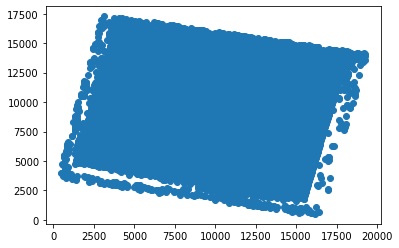

In [9]:
plt.scatter(keep_bbox['xc_dom'], keep_bbox['yc_dom'])

In [5]:
process_area = shp.read_shp2d(field_edge_shp,
                                  geotiff_proj=proj)

[io][shp][fields] Shp fields: {'id': 0}
[io][shp][proj] find ESRI projection file E:/2022_tanashi_broccoli/02_GIS/plot_edge_for _yolo.prj, and successfully obtain projection cartesian


In [6]:
from matplotlib.patches import Polygon
field_area = Polygon(process_area['0'])
in_tag = field_area.contains_points(keep_bbox[['xc_geo', 'yc_geo']])
bbox_dom_in = keep_bbox.loc[in_tag, :]

In [10]:
bbox_dom_in

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,x1_dom,y0_dom,y1_dom,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,keep
24,0,3900,1356,871,52,35,0.806793,1330,1382,854,...,1382,4754,4789,368059.703373,3.956058e+06,368059.597397,3.956058e+06,368059.809349,3.956058e+06,True
27,0,3900,1412,1148,40,44,0.850691,1392,1432,1126,...,1432,5026,5070,368059.931629,3.956057e+06,368059.850109,3.956057e+06,368060.013149,3.956057e+06,True
28,0,3900,1446,1322,38,48,0.877491,1427,1465,1298,...,1465,5198,5246,368060.070213,3.956056e+06,368059.992769,3.956056e+06,368060.147657,3.956056e+06,True
76,1300,3900,1397,1482,30,14,0.539287,1382,1412,1475,...,2712,5375,5389,368065.169295,3.956055e+06,368065.108155,3.956055e+06,368065.230435,3.956055e+06,True
78,1300,3900,229,917,42,42,0.643204,208,250,896,...,1550,4796,4838,368060.408522,3.956058e+06,368060.322925,3.956058e+06,368060.494118,3.956058e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16347,16900,13000,469,33,40,40,0.864891,449,489,13,...,17389,13013,13053,368124.972437,3.956024e+06,368124.890917,3.956024e+06,368125.053957,3.956024e+06,True
16348,16900,13000,915,425,45,40,0.865143,893,938,405,...,17838,13405,13445,368126.790335,3.956023e+06,368126.700663,3.956023e+06,368126.884083,3.956023e+06,True
16349,16900,13000,602,543,49,49,0.865505,577,626,518,...,17526,13518,13567,368125.514546,3.956022e+06,368125.412646,3.956022e+06,368125.612370,3.956022e+06,True
16350,16900,13000,774,646,53,61,0.865972,747,800,616,...,17700,13616,13677,368126.215618,3.956022e+06,368126.105566,3.956022e+06,368126.321595,3.956022e+06,True


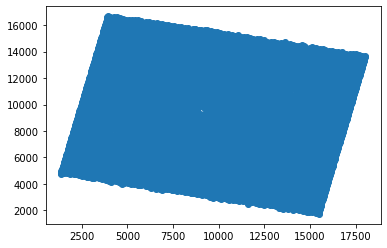

In [12]:
plt.scatter(bbox_dom_in['xc_dom'], bbox_dom_in['yc_dom'])

In [13]:
bbox_dom_in["fid"] = bbox_dom_in.index.values
bbox_dom_in["x_geo"] = bbox_dom_in["xc_geo"]
bbox_dom_in["y_geo"] = bbox_dom_in["yc_geo"]

C:\Users\CREST\AppData\Local\Temp/ipykernel_5500/2534368522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_dom_in["fid"] = bbox_dom_in.index.values
C:\Users\CREST\AppData\Local\Temp/ipykernel_5500/2534368522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbox_dom_in["x_geo"] = bbox_dom_in["xc_geo"]
C:\Users\CREST\AppData\Local\Temp/ipykernel_5500/2534368522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [14]:
bbox_dom_in

,offset_x,offset_y,xc,yc,w,h,thresh,x0,x1,y0,...,xc_geo,yc_geo,x0_geo,y0_geo,x1_geo,y1_geo,keep,fid,x_geo,y_geo
24,0,3900,1356,871,52,35,0.806793,1330,1382,854,...,368059.703373,3.956058e+06,368059.597397,3.956058e+06,368059.809349,3.956058e+06,True,24,368059.703373,3.956058e+06
27,0,3900,1412,1148,40,44,0.850691,1392,1432,1126,...,368059.931629,3.956057e+06,368059.850109,3.956057e+06,368060.013149,3.956057e+06,True,27,368059.931629,3.956057e+06
28,0,3900,1446,1322,38,48,0.877491,1427,1465,1298,...,368060.070213,3.956056e+06,368059.992769,3.956056e+06,368060.147657,3.956056e+06,True,28,368060.070213,3.956056e+06
76,1300,3900,1397,1482,30,14,0.539287,1382,1412,1475,...,368065.169295,3.956055e+06,368065.108155,3.956055e+06,368065.230435,3.956055e+06,True,76,368065.169295,3.956055e+06
78,1300,3900,229,917,42,42,0.643204,208,250,896,...,368060.408522,3.956058e+06,368060.322925,3.956058e+06,368060.494118,3.956058e+06,True,78,368060.408522,3.956058e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16347,16900,13000,469,33,40,40,0.864891,449,489,13,...,368124.972437,3.956024e+06,368124.890917,3.956024e+06,368125.053957,3.956024e+06,True,16347,368124.972437,3.956024e+06
16348,16900,13000,915,425,45,40,0.865143,893,938,405,...,368126.790335,3.956023e+06,368126.700663,3.956023e+06,368126.884083,3.956023e+06,True,16348,368126.790335,3.956023e+06
16349,16900,13000,602,543,49,49,0.865505,577,626,518,...,368125.514546,3.956022e+06,368125.412646,3.956022e+06,368125.612370,3.956022e+06,True,16349,368125.514546,3.956022e+06
16350,16900,13000,774,646,53,61,0.865972,747,800,616,...,368126.215618,3.956022e+06,368126.105566,3.956022e+06,368126.321595,3.956022e+06,True,16350,368126.215618,3.956022e+06


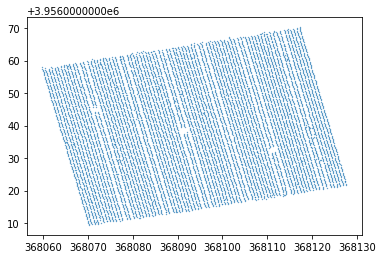

In [16]:
plt.scatter(bbox_dom_in.x_geo, bbox_dom_in.y_geo, s=0.1)

# 06_order_by_ridge.py

In [18]:
# read data
header = geotiff.get_header(r"E:\2022_tanashi_broccoli\01_metashape_projects\outputs\broccoli_tanashi_5_20211101_0_dom.tif")
proj = header['proj']
process_area = shp.read_shp2d(r"E:\2022_tanashi_broccoli\02_GIS\plot_edge_for_yolo.shp",
                              geotiff_proj=proj)

center_points = shp.read_shp2d(r"E:\2022_tanashi_broccoli\10_root_position\shapefiles\edited_center_points.shp",
                              geotiff_proj=proj)

[io][shp][fields] Shp fields: {'id': 0}
[io][shp][proj] find ESRI projection file E:\2022_tanashi_broccoli\02_GIS\plot_edge_for_yolo.prj, and successfully obtain projection cartesian
[io][shp][fields] Shp fields: {'name': 0}  
[io][shp][proj] could not find ESRI projection file E:\2022_tanashi_broccoli\10_root_position\shapefiles\edited_center_points.prj, could not operate auto-convention, Please convert projection system manually.


In [105]:
center_points_np = np.concatenate(list(center_points.values()),0)
center_points_np

array([[ 368059.70337271, 3956057.88353261],
       [ 368059.93162897, 3956056.75447929],
       [ 368060.07021313, 3956056.04525446],
       ...,
       [ 368101.64654537, 3956066.66905537],
       [ 368102.57079688, 3956049.19636116],
       [ 368123.85824642, 3956022.79668753]])

In [31]:
center_points_px = geotiff.geo2pixel(xy, header)
center_points_px

array([[ 1356,  4771],
       [ 1412,  5048],
       [ 1446,  5222],
       ...,
       [11646,  2616],
       [11873,  6902],
       [17096, 13379]])

In [36]:
process_area_px = geotiff.geo2pixel(process_area['0'], header)

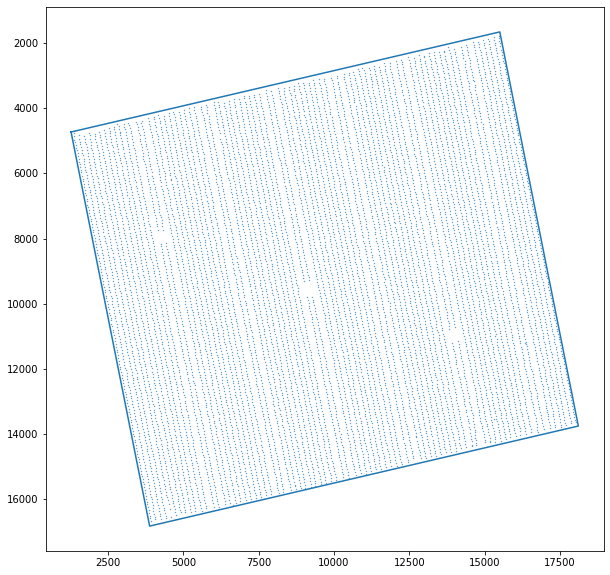

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(*process_area_px.T)
plt.scatter(*center_points_px.T, s=0.1)
ax.invert_yaxis()

plt.show()

In [49]:
# 转换为单位向量
def vector_mod(Ax, By):
    return np.sqrt(np.sum(np.square([Ax, By])))

In [89]:
xu = process_area_px[1,:] - process_area_px[0,:]
yu = process_area_px[1,:] - process_area_px[2,:]

v1 = xu / vector_mod(*xu)
v2 = yu / vector_mod(*yu)

cvtmat = np.vstack([v1, v2]).T

cvt_xy = np.linalg.inv(cvtmat).dot(center_points_px.T).T

In [90]:
cvt_xy

array([[   319.6954398 ,  -4949.6751579 ],
       [   316.0393456 ,  -5232.2551095 ],
       [   312.59229353,  -5409.51197743],
       ...,
       [ 10832.74372131,  -5013.49733669],
       [ 10151.06212384,  -9250.95707429],
       [ 13891.18438144, -16683.87244178]])

In [91]:
process_area_cvt = np.linalg.inv(cvtmat).dot(process_area_px.T).T

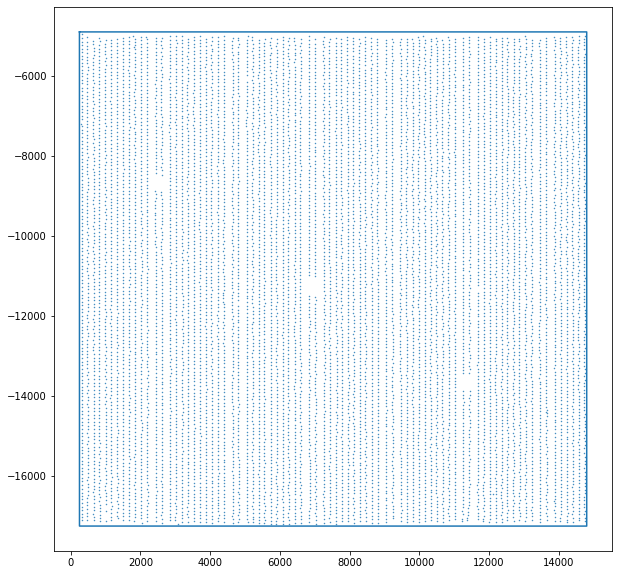

In [92]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(*process_area_cvt.T)
ax.scatter(*cvt_xy.T, s=0.2)

plt.show()

# DETECT BY RIDGE

In [61]:
ridge_distance_pixel = 11

In [66]:
from scipy.signal import find_peaks

In [70]:
if ridge_direction == "x":
    v, n = np.unique((cvt_xy[:,0] / 10).astype(int) * 10, return_counts=True)
else:
    v, n = np.unique((cvt_xy[:,1] / 10).astype(int) * 10, return_counts=True)

peaks, _ = find_peaks(n, distance=3, height=20)

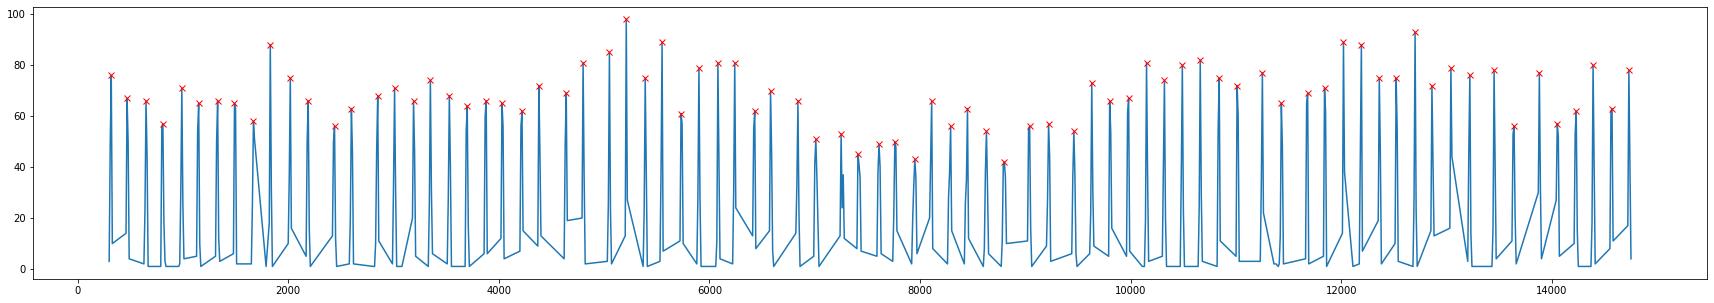

In [71]:
fig, ax = plt.subplots(1,1, figsize=(30,5))
ax.plot(v,n)
for i in peaks:
    ax.plot(v[i], n[i], 'rx')
plt.show()

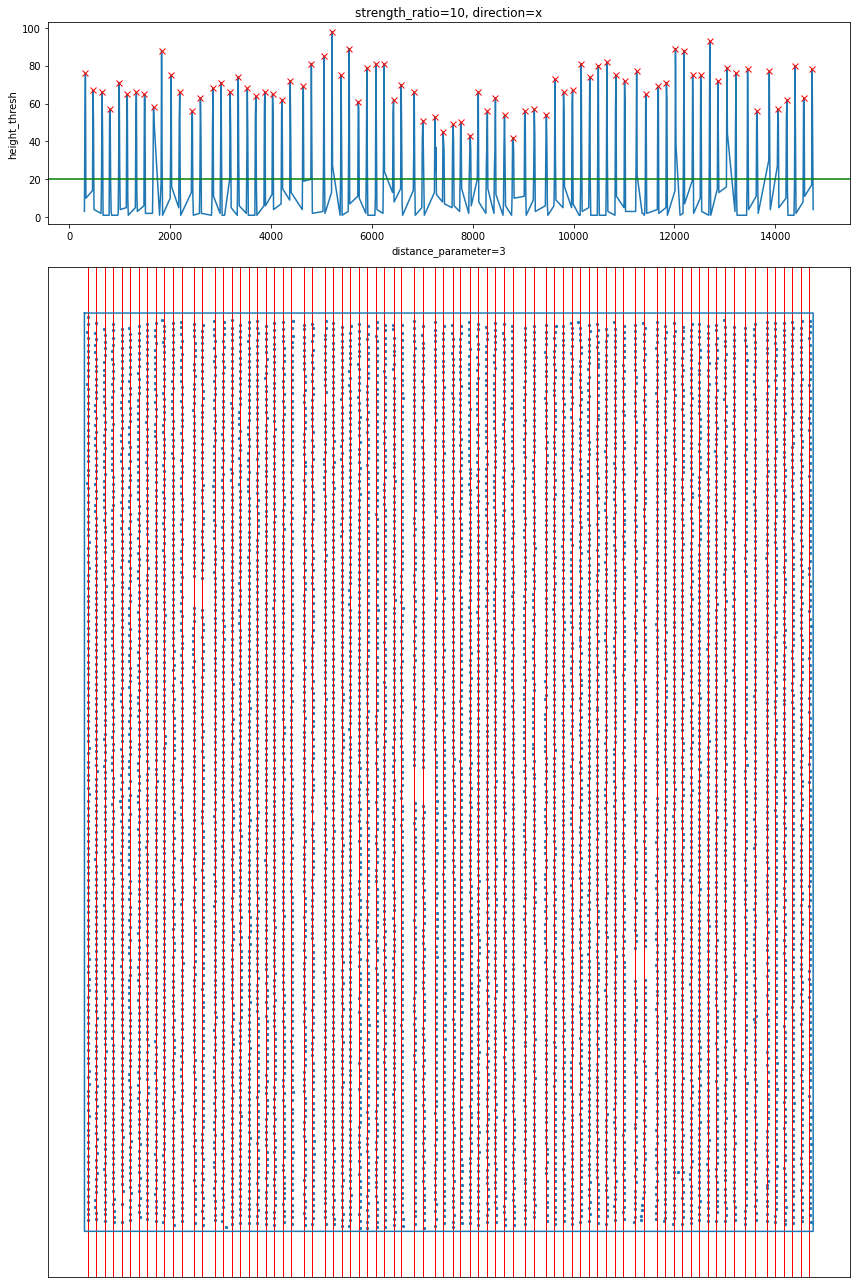

In [104]:
fig, ax = plt.subplots(2,1, figsize=(12,18), gridspec_kw={'height_ratios': [1, 5]})

ax[0].plot(v,n)
for i in peaks:
    ax[0].plot(v[i], n[i], 'rx')
    ax[1].axvline(x=v[i],c='r', lw=1)
    
ax[0].axhline(y=20, c='g')
    
ax[1].plot(*process_area_cvt.T)
ax[1].scatter(*cvt_xy.T, s=5)

ax[0].set_ylabel("height_thresh")
ax[0].set_xlabel(f"distance_parameter={3}")
ax[0].set_title(f"strength_ratio={10}, direction={'x'}")

ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

In [138]:
peak_x = v[peaks]
buffer = peak_x[1:] - peak_x[:-1]
buffer = np.hstack([max(buffer), buffer, max(buffer)])
buffer

array([260, 150, 180, 160, 180, 160, 180, 160, 180, 160, 190, 170, 250,
       160, 250, 160, 180, 160, 180, 170, 180, 150, 190, 160, 260, 160,
       250, 160, 180, 160, 180, 170, 180, 160, 190, 150, 260, 170, 240,
       160, 200, 150, 190, 160, 180, 160, 180, 170, 240, 180, 240, 170,
       170, 180, 170, 170, 170, 170, 180, 170, 240, 180, 250, 160, 180,
       170, 170, 160, 180, 160, 180, 180, 230, 190, 240, 170, 180, 160,
       180, 160, 260])

In [169]:
order_df = pd.DataFrame({"x_geo": center_points_np[:,0], 
              "y_geo": center_points_np[:,1],
              "cvt_x": cvt_xy[:,0],
              "cvt_y": cvt_xy[:,1],
              "fid": -1})
order_df

,x_geo,y_geo,cvt_x,cvt_y,fid
0,368059.703373,3.956058e+06,319.695440,-4949.675158,-1
1,368059.931629,3.956057e+06,316.039346,-5232.255110,-1
2,368060.070213,3.956056e+06,312.592294,-5409.511977,-1
3,368065.169295,3.956055e+06,1501.744229,-5829.770609,-1
4,368060.408522,3.956058e+06,479.109428,-5031.129093,-1
...,...,...,...,...,...
11095,368125.897690,3.956023e+06,14394.704188,-16720.906014,-1
11096,368091.822526,3.956056e+06,7940.791002,-6990.977970,-1
11097,368101.646545,3.956067e+06,10832.743721,-5013.497337,-1
11098,368102.570797,3.956049e+06,10151.062124,-9250.957074,-1


In [111]:
from sklearn.linear_model import RANSACRegressor

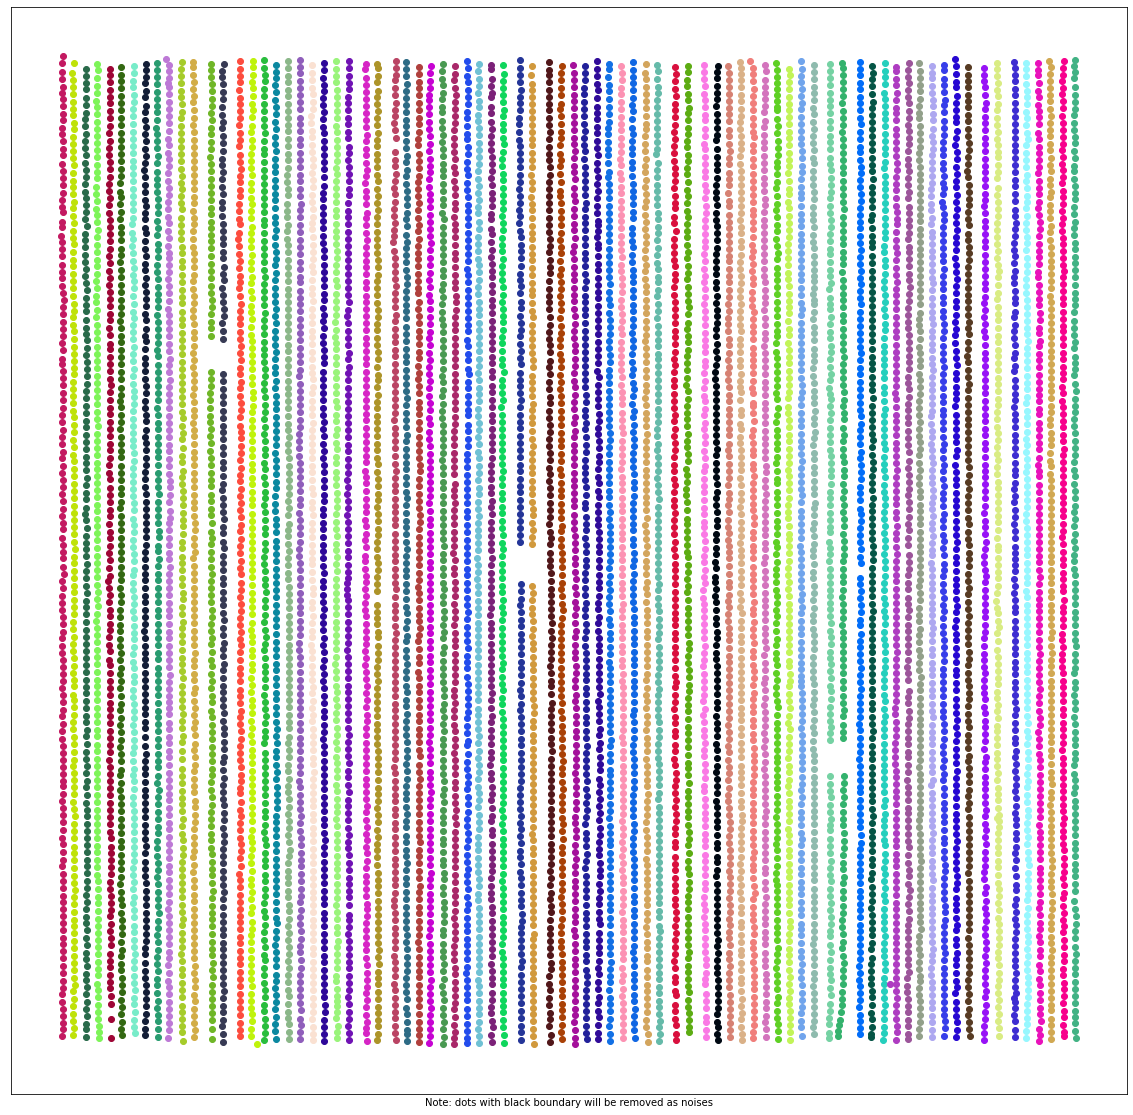

In [211]:
fid_st = 1

fig, ax = plt.subplots(1,1, figsize=(20,20))

for i, p in enumerate(peak_x):
    range_st = p - buffer[i] * 0.5
    range_ed = p + buffer[i+1] * 0.5
    
    selected = (order_df.cvt_x >= range_st ) & (order_df.cvt_x <= range_ed)
    selected_xy = order_df.loc[selected, ['cvt_x', 'cvt_y']]
    
    color=np.random.rand(3)
    
    
    #X = np.ones((len(selected_xy), 1))
    #X[:, 0] = selected_xy.cvt_y

    #reg = RANSACRegressor(residual_threshold=50, max_trials=1000).fit(X, selected_xy['cvt_x'])
    #inlier_mask = reg.inlier_mask_'
    inlier_mask = np.ones(len(selected_xy)).astype(bool)
    
    # remove outlier and sort by Y axis
    selected_xy_sort = selected_xy.loc[inlier_mask,:].sort_values(by=['cvt_y'], ascending=False)
    fid = np.linspace(fid_st, len(selected_xy_sort)+fid_st-1, num=len(selected_xy_sort)).astype(int)
    
    selected_xy_sort['fid'] = fid
    order_df.loc[selected_xy_sort.index, 'fid'] = selected_xy_sort.fid
    
    fid_st += len(selected_xy_sort)
    
    non_selected_xy = selected_xy.loc[~inlier_mask,:]
    ax.scatter(selected_xy_sort.cvt_x, selected_xy_sort.cvt_y, color=color)
    ax.scatter(non_selected_xy.cvt_x, non_selected_xy.cvt_y, color=color, edgecolors='k', alpha=0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Note: dots with black boundary will be removed as noises")
plt.show()

In [209]:
X = np.ones((len(selected_xy), 1))
X[:, 0] = selected_xy.cvt_y

reg = RANSACRegressor(residual_threshold=5000, max_trials=1000).fit(X, selected_xy['cvt_x'])
inlier_mask = reg.inlier_mask_

inlier_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

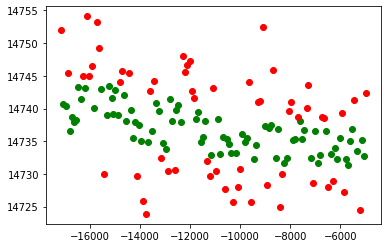

In [199]:
plt.scatter(X[inlier_mask, 0], selected_xy['cvt_x'][inlier_mask], c='g')
plt.scatter(X[~inlier_mask, 0],  selected_xy['cvt_x'][~inlier_mask], c='r')
plt.show()

In [158]:
order_df

,x_geo,y_geo,cvt_x,cvt_y,fid
0,368059.703373,3.956058e+06,319.695440,-4949.675158,1
1,368059.931629,3.956057e+06,316.039346,-5232.255110,4
2,368060.070213,3.956056e+06,312.592294,-5409.511977,6
3,368065.169295,3.956055e+06,1501.744229,-5829.770609,954
4,368060.408522,3.956058e+06,479.109428,-5031.129093,135
...,...,...,...,...,...
11095,368125.897690,3.956023e+06,14394.704188,-16720.906014,10729
11096,368091.822526,3.956056e+06,7940.791002,-6990.977970,5756
11097,368101.646545,3.956067e+06,10832.743721,-5013.497337,7959
11098,368102.570797,3.956049e+06,10151.062124,-9250.957074,7447


In [210]:
np.ones(1).astype(bool)

array([ True])

In [159]:
min(order_df.fid)

-1

In [145]:
fid_positive = order_df[order_df.fid > 0]

In [160]:
fid_negative = order_df[order_df.fid < 0]

In [161]:
fid_negative

,x_geo,y_geo,cvt_x,cvt_y,fid
57,368061.036226,3.956052e+06,327.330612,-6465.350911,-1
82,368060.192493,3.956056e+06,326.317264,-5488.174791,-1
213,368062.360928,3.956046e+06,333.854021,-7976.694813,-1
265,368062.658476,3.956044e+06,331.425897,-8334.218145,-1
341,368068.886611,3.956057e+06,2453.330748,-5743.538942,-1
...,...,...,...,...,...
10514,368119.905963,3.956036e+06,13623.727153,-13322.922418,-1
10529,368120.293184,3.956034e+06,13627.203803,-13757.421222,-1
10612,368120.839368,3.956032e+06,13625.163924,-14402.489109,-1
10881,368121.308109,3.956022e+06,13215.375129,-16848.021635,-1


In [212]:
bool('False')

True

In [163]:
len(fid_negative)

84

In [165]:
fid = np.linspace(fid_st, len(fid_negative)+fid_st-1, num=len(fid_negative)).astype(int)
fid

array([11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025,
       11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034,
       11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043,
       11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052,
       11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061,
       11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070,
       11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079,
       11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088,
       11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097,
       11098, 11099, 11100])

In [166]:
fid_negative['fid'] = fid
order_df.loc[fid_negative.index, 'fid'] = fid_negative.fid

In [ ]:
fid_negative

,x_geo,y_geo,cvt_x,cvt_y,fid
57,368061.036226,3.956052e+06,327.330612,-6465.350911,11017
82,368060.192493,3.956056e+06,326.317264,-5488.174791,11018
213,368062.360928,3.956046e+06,333.854021,-7976.694813,11019
265,368062.658476,3.956044e+06,331.425897,-8334.218145,11020
341,368068.886611,3.956057e+06,2453.330748,-5743.538942,11021
...,...,...,...,...,...
10514,368119.905963,3.956036e+06,13623.727153,-13322.922418,11096
10529,368120.293184,3.956034e+06,13627.203803,-13757.421222,11097
10612,368120.839368,3.956032e+06,13625.163924,-14402.489109,11098
10881,368121.308109,3.956022e+06,13215.375129,-16848.021635,11099
